# Preparation

In [1]:
#!git clone https://github.com/facebookresearch/detr

In [2]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
#import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion, DETR
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

#added
import json
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from numpy.random import rand, randint, ranf, randn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torchvision.transforms.functional as tf
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)
%matplotlib inline

/home/takeshi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

# Preparing the Data
## KITTI

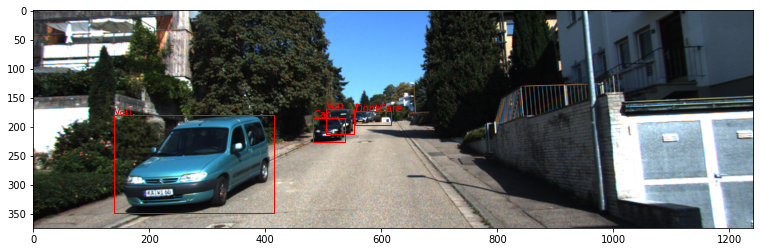

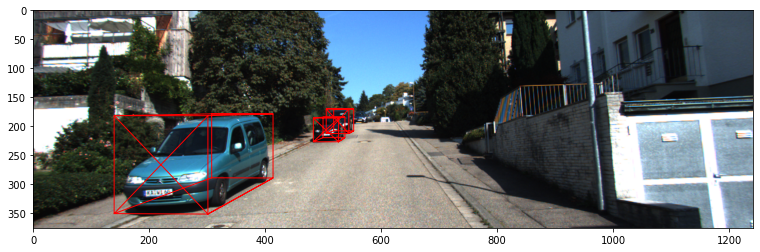

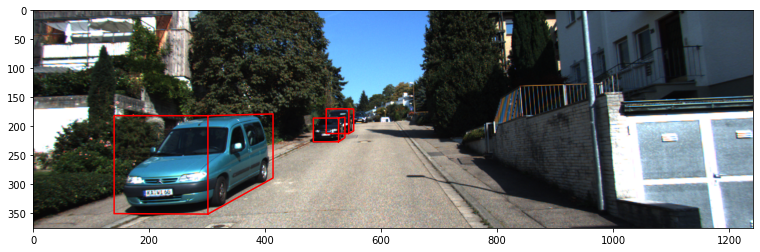

In [4]:
class KITTIData():
    def __init__(self, KITTIPath=None):
        if not KITTIPath==None:
            self.dataset_path = KITTIPath
        else:
            self.dataset_path = "../../../Dataset/KITTI/training/"
        self.img_folder_path = self.dataset_path + "image_2/"
        self.label_folder_path = self.dataset_path + "label_2/"
        self.calib_folder_path = self.dataset_path + "calib/"
        
        self.img_names = glob(self.img_folder_path + "*.png")
        for i in range(len(self.img_names)):
            self.img_names[i] = self.img_names[i].split('/')[-1][:-4]
        
        #print("Preparing", len(self.img_names), "images from KITTI.")
        #
        #self.annotations_list = pd.DataFrame()
        #names = ["type", "truncated", "occluded", "alpha", "left", "top", "right", "bottom",
        #         "height", "width", "length", "x", "y", "z", "rotation_y", ]
        #
        #for img_name in tqdm(self.img_names):
        #    label_path = self.label_folder_path + img_name + ".txt"
        #    annotations = pd.read_csv(label_path, names = names, sep='\s+')
        #    annotations["img_name"] = img_name
        #    self.annotations_list = self.annotations_list.append(annotations)
        #self.annotations_list = self.annotations_list[["img_name"]+names]
        #
        #print("Loading completed!")
        self.annotation_items = ["type", "truncated", "occluded", "alpha", "left", "top", "right", "bottom",
                                 "height", "width", "length", "x", "y", "z", "rotation_y", ]
        
    def __len__(self):
        return len(self.img_names)
        
    def line2P(self, l):
        P_elem = l.split()[1:]
        P = np.array(P_elem, dtype=np.float).reshape(3,-1)
        return P
    
    def readCalib(self, calib_name):
        calib_name = self.calib_folder_path + calib_name + ".txt"
        with open(calib_name) as f:
            P0 = self.line2P(f.readline())
            P1 = self.line2P(f.readline())
            P2 = self.line2P(f.readline())
            P3 = self.line2P(f.readline())
            R0_rect = self.line2P(f.readline())
            Tr_velo_to_cam = self.line2P(f.readline())
            Tr_imu_to_velo = self.line2P(f.readline())
        return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo
    
    def getPILImg(self, img_name):
        img_path = self.img_folder_path + img_name + ".png"
        img = Image.open(img_path)
        return img
    
    def getAnnotation(self, img_name):
        #return self.annotations_list[self.annotations_list["img_name"]==img_name]
        label_path = self.label_folder_path + img_name + ".txt"
        annotation = pd.read_csv(label_path, names=self.annotation_items, sep='\s+')
        annotation["img_name"] = img_name
        return annotation
    
    def plot2Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        for _, anno in annotations.iterrows():
            _type,left,top,right,bottom = anno["type"],anno["left"],anno["top"],anno["right"],anno["bottom"]
            plt.plot([left,right,right,left,left],
                     [top,top,bottom,bottom,top],
                     color="r",linewidth=1
                )
            plt.text(left, top, _type, color="r")

    def selectVisiblePoint(self, pts3D):
        # 直方体の8点から、隠れた点を除いて出力する
        face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                              [0,1,1,0,0,1,1,0], # right
                              [0,0,1,1,0,0,1,1], # back
                              [1,0,0,1,1,0,0,1]  # left
                             ])
    
        # 直方体の中心位置を計算
        c_rectangular = np.sum(pts3D, axis=1)/8
    
        # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
        visible_mask = np.zeros(8)
        for i in range(4):
            p_in_plane = pts3D * face_mask[i] # 平面の4つの頂点
            c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
            normal = c_plane - c_rectangular# 平面の法線ベクトル
            c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
            if np.dot(c_to_O, normal)>0:
                visible_mask += face_mask[i]
        return pts3D[:,visible_mask!=0]
    
    def projectToImage(self, pts3D, P):
        P = np.array(P)
        
        ones = np.ones([1,pts3D.shape[1]])
        pts3D = np.append(pts3D, ones, axis=0)
        pts2D = np.dot(P, pts3D)
        pts2D[0] /= pts2D[2]
        pts2D[1] /= pts2D[2]
        pts2D = np.delete(pts2D, obj=2, axis=0)
        return pts2D
    
    def calc3Dcoord(self, obj, P):
        # 直方体の各頂点のxyz座標を計算
        face_idx = np.array([[0,1,5,4], # front face
                             [1,2,6,5], # right face
                             [2,3,7,6], # back face
                             [3,0,4,7]]) # left face
        ry = obj["rotation_y"]
        R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                      [          0, 1,          0],
                      [-np.sin(ry), 0, np.cos(ry)]],
                     dtype=np.float)
        l = obj["length"]
        w = obj["width"]
        h = obj["height"]
        corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                            [0,0,0,0,-h,-h,-h,-h],
                            [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                           dtype=np.float).reshape(3,-1)
        pts3D = np.dot(R,corners)
        xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
        pts3D += xyz
        return pts3D
    
    def calcPseudo3Dbb(self, obj, P):
        pts3D = self.calc3Dcoord(obj, P)
        pts3D_visible = self.selectVisiblePoint(pts3D)
        pts2D_visible = self.projectToImage(pts3D_visible, P)
        
        # pts2D_visibleをx座標でソートする。下の順番になる
        # left-top, left-bottom, (mid-top, mid-bottom), right-top, right-bottom
        pts2D_aligned = pts2D_visible[:,pts2D_visible[0].argsort()].T
        
        # (mid-top, mid-bottom)がない場合はnp.nan埋めする。6x2行列になる
        if pts2D_aligned.shape[0]==4:
            pts2D_aligned = np.insert(pts2D_aligned, [2,2], [np.nan,np.nan], axis=0)
        
        return pts2D_aligned
    
    def array2Pseudo3Dbb(self, array2D):
        # convert from array to dictionary
        obj = {}
        obj["leftTop"] = array2D[0]
        obj["leftBottom"] = array2D[1]
        obj["midTop"] = array2D[2]
        obj["midBottom"] = array2D[3]
        obj["rightTop"] = array2D[4]
        obj["rightBottom"] = array2D[5]
        if np.isnan(array2D[2:4,:]).all():
            obj["is_visible2surface"] = False
        else:
            obj["is_visible2surface"] = True
        return obj
    
    @staticmethod
    def array2bb(array2D):
        # convert from array to 2Dbb
        array2D = array2D[np.logical_not(np.isnan(array2D))].reshape([-1, 2])
        x0 = np.min(array2D[:,0])
        x1 = np.max(array2D[:,0])
        y0 = np.min(array2D[:,1])
        y1 = np.max(array2D[:,1])
        c_x, c_y = (x0+x1)/2, (y0+y1)/2
        w, h = x1-x0, y1-y0
        
        return [c_x, c_y, w, h]
    
    def compute3Dbb(self, obj, P):
        face_idx = np.array([[1,2,6,5], # front face
                             [2,3,7,6], # left face
                             [3,4,8,7], # back face
                             [4,1,5,8]]) # right face
        
        corner3D = self.calc3Dcoord(obj, P)
        if any(corner3D[2,:]<0.1): # 対象物の前後距離<.1だったら出力しない
            corner2D = []
        else:
            corner2D = self.projectToImage(corner3D, P);
        
        return corner2D, face_idx
    
    def plot3Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            corner2D, face_idx = self.compute3Dbb(anno, P2)
            if len(corner2D)==0:
                continue
            plt.plot(corner2D[0,[2,3,0,1,2,6,7,4,5,6,7,3,0,5,1,4,0]],
                     corner2D[1,[2,3,0,1,2,6,7,4,5,6,7,3,0,5,1,4,0]],
                     color="r",linewidth=1)
            
        plt.xlim([0,img.size[0]])
        plt.ylim([img.size[1],0])
    
    def plotPseudo3Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            obj = self.array2Pseudo3Dbb(self.calcPseudo3Dbb(anno, P2))
            #if len(point2D)==0:
            #    continue
                
            coord2D = [obj["leftTop"],obj["leftBottom"],obj["rightBottom"],obj["rightTop"]]
            if obj["is_visible2surface"]==True:
                coord2D.insert(0, obj["midBottom"])
                coord2D.insert(1, obj["midTop"])
                coord2D.insert(4, obj["midBottom"])
                coord2D.insert(7, obj["midTop"])
            else:
                coord2D.insert(5, obj["leftTop"])
            coord2D = np.array(coord2D)
            plt.plot(coord2D[:,0],coord2D[:,1], "r")
            
        plt.xlim([0,img.size[0]])
        plt.ylim([img.size[1],0])

    
KITTIDataset = KITTIData()
i = 2
KITTIDataset.plot2Dbb(KITTIDataset.img_names[i])
KITTIDataset.plot3Dbb(KITTIDataset.img_names[i])
KITTIDataset.plotPseudo3Dbb(KITTIDataset.img_names[i])

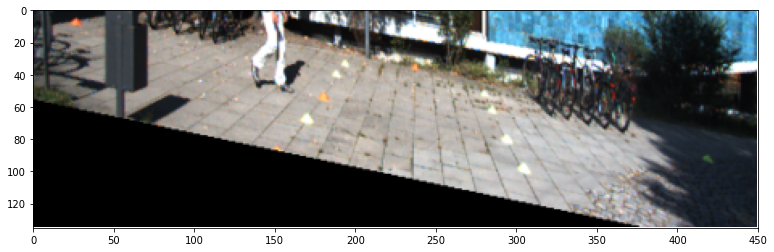

In [5]:
class ImagePreprocessor(KITTIData):
    def __init__(self, training=False, fliplr=False, shear_x=False, shear_y=False,
                 scale=False, crop=False, offset=False):
        super().__init__()
        
        self.training = training
        self.augFlags = {
            "fliplr":fliplr,
            "shear_x":shear_x,
            "shear_y":shear_y,
            "scale":scale,
            "crop":crop,
            "offset":offset
            }
        self.augParams = {
            "fliplr":False,
            "shear_x":0,
            "shear_y":0,
            "scale_x":1,
            "scale_y":1,
            "offset":[0,0]
            }
        self.outSize = np.array([450,135]) # x,y
        self.suppression_captureRate = .15
    
    def setAugParams(self, img):
        self.inSize = np.array(img.size) # x,y
        
        if self.training:
            if self.augFlags["fliplr"]:
                self.augParams["fliplr"] = rand()>.5
            if self.augFlags["shear_x"]:
                self.augParams["shear_x"] = (rand()-.5)*2*self.augFlags["shear_x"]
            if self.augFlags["shear_y"]:
                self.augParams["shear_y"] = (rand()-.5)*2*self.augFlags["shear_y"]
            if self.augFlags["scale"]:
                self.augParams["crop_x"] = randint((2*self.augFlags["scale"]-1)*self.inSize[0],self.inSize[0])
                self.augParams["crop_y"] = randint((2*self.augFlags["scale"]-1)*self.inSize[1],self.inSize[1])
                self.augParams["offset_x"] = randint(0,self.inSize[0]-self.augParams["crop_x"])
                self.augParams["offset_y"] = randint(0,self.inSize[1]-self.augParams["crop_y"])
    
    def preprocessImage(self, PILimg):
        img = PILimg
        self.setAugParams(img)
        
        if self.training:
            if self.augFlags["fliplr"] and self.augParams["fliplr"]:
                img = ImageOps.mirror(img)
            affined = tf.affine(img, angle=0,
                                    translate=(0,0),
                                    scale=self.augFlags["scale"],
                                    shear=[self.augParams["shear_x"],self.augParams["shear_y"]]
                                   )
            cropped = tf.crop(affined, self.augParams["offset_y"], self.augParams["offset_x"],
                              self.augParams["crop_y"], self.augParams["crop_x"])
        else:
            cropped = img
        resized = transforms.Resize(self.outSize[::-1])(cropped)
        resized = transforms.ToTensor()(resized)
        
        return resized
    
    def captured_rate(self, bb_ccwh, img_size):
        # determine the (x, y)-coordinates of the intersection rectangle
        c_x, c_y, w, h = bb_ccwh
        img_w, img_h = img_size[0], img_size[1]
        
        area_bb = w*h
        # intersection area
        x0 = max(0, c_x-w/2)
        x1 = min(img_w, c_x+w/2)
        y0 = max(0, c_y-h/2)
        y1 = min(img_h, c_y+h/2)
        area_intersection = (x1-x0)*(y1-y0)
        
        if x1<x0 or y1<y0:
            area_intersection = 0
        
        return area_intersection/(area_bb+.00001)
    
    def preprocessAnno(self, array):
        # fliplr, scale, shear_x, shear_y, offset, crop
        if self.training:
            if self.augFlags["fliplr"] and self.augParams["fliplr"]:
                array[:,0] = self.inSize[0] - array[:,0]
                array[0:2,:],array[4:6,:] = array[4:6,:].copy(),array[0:2,:].copy()
            if self.augFlags["scale"]:
                array = array*self.augFlags["scale"] + self.inSize*(1-self.augFlags["scale"])/2
            if self.augFlags["shear_x"]:
                off_y = np.array(array[:,1]-self.inSize[1]/2)
                array[:,0] -= off_y*np.tan(self.augParams["shear_x"]/180*np.pi)
            if self.augFlags["shear_y"]:
                off_x = np.array(array[:,0]-self.inSize[0]/2)
                array[:,1] -= off_x*np.tan(self.augParams["shear_y"]/180*np.pi)
            if self.augFlags["scale"]:
                array -= np.array([self.augParams["offset_x"], self.augParams["offset_y"]])
                array *= self.outSize/np.array([self.augParams["crop_x"], self.augParams["crop_y"]])
        else:
            array *= self.outSize/self.inSize
        return array
    
    def anno2objsList(self, img_name):
        # return list which contains objects
        annotations = self.getAnnotation(img_name)
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        objects = []
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            pseudo3Dbb = self.calcPseudo3Dbb(anno, P2)
            pseudo3Dbb_aug = self.preprocessAnno(pseudo3Dbb)
            
            # 元画像に写っている面積が小さければ出力しない
            # 変換後の画像に写っている面積が小さければ出力しない
            bb2D_aug = self.array2bb(pseudo3Dbb_aug)
            bb2D = self.array2bb(pseudo3Dbb)
            if self.captured_rate(bb2D, self.inSize)<self.suppression_captureRate:
                continue
            elif self.captured_rate(bb2D_aug, self.outSize)<self.suppression_captureRate:
                continue
            obj = self.array2Pseudo3Dbb(pseudo3Dbb_aug)
            objects.append(obj)
        return objects
    
    def anno2listsObj(self, img_name):
        # return dictionary which contains lists of object informatation
        annotations = self.getAnnotation(img_name)
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        listObject = {"coords":[], "poses":[]}
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            pseudo3Dbb = self.calcPseudo3Dbb(anno, P2)
            pseudo3Dbb_aug = self.preprocessAnno(pseudo3Dbb)
            
            # 元画像に写っている面積が小さければ出力しない
            # 変換後の画像に写っている面積が小さければ出力しない
            bb2D_aug = self.array2bb(pseudo3Dbb_aug)
            bb2D = self.array2bb(pseudo3Dbb)
            if self.captured_rate(bb2D, self.inSize)<self.suppression_captureRate:
                continue
            elif self.captured_rate(bb2D_aug, self.outSize)<self.suppression_captureRate:
                continue
            obj = self.array2Pseudo3Dbb(pseudo3Dbb_aug)
            
            listObject["coords"].append(pseudo3Dbb_aug)
            listObject["poses"].append([obj["is_visible2surface"]])
        return listObject
    
    def plotPseudo3Dbb(self, img_name):
        img = self.getPILImg(img_name)
        img = self.preprocessImage(img)
        img = np.rollaxis(np.array(img),0,3)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        objs = self.anno2objsList(img_name)
        for obj in objs:
            coord2D = [obj["leftTop"],obj["leftBottom"],obj["rightBottom"],obj["rightTop"]]
            if obj["is_visible2surface"]==True:
                coord2D.insert(0, obj["midBottom"])
                coord2D.insert(1, obj["midTop"])
                coord2D.insert(4, obj["midBottom"])
                coord2D.insert(7, obj["midTop"])
            else:
                coord2D.insert(5, obj["leftTop"])
            coord2D = np.array(coord2D)
            plt.plot(coord2D[:,0],coord2D[:,1], "r")
        
        plt.xlim([0,img.shape[1]])
        plt.ylim([img.shape[0],0])

    def __getitem__(self, idx):
        # Get data for pytorch
        # preprocess is done in self.getitem, and return except for gt
        # because batch process cannot treat not-fixed length
        img_name = self.img_names[idx]
        img = self.getPILImg(img_name)
        img = self.preprocessImage(img)
        
        # regularization of coordination
        targets = self.anno2listsObj(img_name)
        if len(targets["coords"])>0:
            targets["coords"] = torch.as_tensor(targets["coords"])
            targets["coords"] /= self.outSize
            targets["coords"] = targets["coords"].reshape([-1,12])
        else:
            targets["coords"] = torch.zeros([0,12], dtype=torch.float64)
        targets["poses"] = torch.as_tensor(targets["poses"]).float()
        # todo : label設定する
        targets["labels"] = torch.zeros(targets["coords"].shape[-2]).long() # .shape[-1]はcoord数の12、.shape[-1]はlabel数
            
        # set bounding box for matching
        coords = targets["coords"].detach().numpy()
        bbox_normed = torch.as_tensor([self.array2bb(coord) for coord in coords], dtype=torch.float64).reshape([-1,4])
        targets["boxes"] = bbox_normed*torch.as_tensor([1,135/450,1,135/450]) # アスペクト比を調整
        
        return img, targets

vehicleAug = ImagePreprocessor(training=True, fliplr=True, shear_x=False, shear_y=10,
                 scale=0.7, crop=False, offset=False)
i = 1
vehicleAug.plotPseudo3Dbb(KITTIDataset.img_names[i])

In [6]:
len(vehicleAug)

7481

# Creating Dataset

In [7]:
img_list = vehicleAug.img_names
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)
print("train dataset has ", len(train_list), "images.")
print("val dataset has ", len(val_list), "images.")

train dataset has  7106 images.
val dataset has  375 images.


In [8]:
class VehicleDataset(Dataset):
    def __init__(self, dataList, training=True):
        self.dataset = ImagePreprocessor(training=training, fliplr=True, shear_x=False, shear_y=10,
                                         scale=0.7, crop=False, offset=False)
        self.dataset.img_names = dataList
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [9]:
train_dataset = VehicleDataset(train_list, training=True)
val_dataset = VehicleDataset(val_list, training=True)
val_dataset_noaug = VehicleDataset(val_list, training=False)

In [10]:
BATCH_SIZE = 16
num_worker = 4

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=num_worker)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=num_worker)
val_loader_noaug = DataLoader(dataset=val_dataset_noaug, batch_size=BATCH_SIZE, shuffle=False,
                              collate_fn=collate_fn, num_workers=num_worker)

# Model

In [11]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=num_classes)
        self.model.pose_embed = nn.Linear(in_features=self.in_features,out_features=1)
        self.model.coord_embed = nn.Linear(in_features=self.in_features,out_features=12)
        self.model.num_classes = num_classes
        self.model.num_queries = num_queries
        
        
        hidden_dim = self.model.transformer.d_model
        self.model.query_embed = nn.Embedding(num_queries, hidden_dim)
        
    def forward(self,images):
        ## from facebook/DETR
        if isinstance(images, (list, torch.Tensor)):
            images = nested_tensor_from_tensor_list(images)
        features, pos = self.model.backbone(images)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.model.transformer(self.model.input_proj(src), mask, self.model.query_embed.weight, pos[-1])[0]

        outputs_class = self.model.class_embed(hs)
        outputs_pose = self.model.pose_embed(hs)
        outputs_coord = self.model.coord_embed(hs)
        out = {'pred_logits': outputs_class[-1],
               'pred_poses': outputs_pose[-1],
               'pred_coords': outputs_coord[-1]}
        return out

# Matcher and Bipartite Matching Loss

In [12]:
matcher = HungarianMatcher()

weight_dict = {'loss_ce': 1, 'loss_poses': 1 , 'loss_coords': 1}

losses = ['labels', 'poses', 'coords']

# Evaluation Function

In [13]:
class SetVehicleCriterion(SetCriterion):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.poseThresh = .5
    
    @staticmethod
    def array2bb(coord, pose, poseThresh):
        # convert from array to 2Dbb
        array2D = coord.reshape([-1, 6, 2]) # shape:[batch, leftTop~rightBottom, (x,y)]
        bbox = np.zeros((array2D.shape[0],4))
        cannotSeeTwoSide = pose.reshape(-1)<poseThresh
        
        tmp = array2D[cannotSeeTwoSide,2:4,:]
        array2D[cannotSeeTwoSide,2:4,:] = np.inf
        x0 = np.min(array2D[:,:,0], axis=1)
        y0 = np.min(array2D[:,:,1], axis=1)
        array2D[cannotSeeTwoSide,2:4,:] = -np.inf
        x1 = np.max(array2D[:,:,0], axis=1)
        y1 = np.max(array2D[:,:,1], axis=1)
        array2D[cannotSeeTwoSide,2:4,:] = tmp
    
        bbox[:,0] = (x0+x1)/2 #cx
        bbox[:,1] = (y0+y1)/2 #cy
        bbox[:,2] = x1-x0 #w
        bbox[:,3] = y1-y0 #h
        
        bbox[:,1] *= 135/450 # 実際のアスペクト比に調整
        bbox[:,3] *= 135/450
    
        return bbox
    
    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes[idx] = target_classes_o
            
        
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        return losses
    
    def loss_poses(self, outputs, targets, indices, num_boxes):
        assert 'pred_poses' in outputs
        losses = {}
        
        idx = self._get_src_permutation_idx(indices)
        src_poses = outputs['pred_poses'].sigmoid()[idx]
        target_poses = torch.cat([t['poses'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        
        loss_poses = F.binary_cross_entropy(src_poses, target_poses)

        losses['loss_poses'] = loss_poses.sum() / num_boxes
        
        return losses
    
    def loss_coords(self, outputs, targets, indices, num_boxes):
        assert 'pred_coords' in outputs
        losses = {}
        
        idx = self._get_src_permutation_idx(indices)
        src_coords = outputs['pred_coords'][idx]
        target_poses = torch.cat([t['poses'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        target_coords = torch.cat([t['coords'][i] for t, (_, i) in zip(targets, indices)], dim=0)
    
        loss_coords = F.l1_loss(src_coords, target_coords, reduction='none')
        
        loss_weight = torch.as_tensor([450, 135]*6)
        loss_coords = loss_coords*loss_weight
        #loss_coords = torch.clamp(loss_coords,0,20) # 誤差が大きすぎるものはcliping
        loss_coords /= 450
        
        # もし車両の2面が見えていなければmidTop,midBottom学習させない
        loss_coords = loss_coords.reshape(-1,6,2)
        loss_mask = torch.ones_like(loss_coords).bool()
        loss_mask[target_poses.reshape(-1)==0,2:4] = False
        loss_coords = loss_coords[loss_mask]
    
        losses['loss_coords'] = loss_coords.sum() / num_boxes
        
        return losses

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'poses': self.loss_poses,
            'coords': self.loss_coords
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)
    
    def forward(self, outputs, targets):
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}
        coords = outputs["pred_coords"].detach().numpy()
        poses = outputs["pred_poses"].detach().numpy()
        
        outputs_without_aux["pred_boxes"] =\
            torch.as_tensor([self.array2bb(coord, pose, self.poseThresh) for coord, pose in zip(coords,poses)])
        
        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

# Engine

In [14]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 30
null_class_coef = 0.5
LR = 2e-5
EPOCHS = 300

In [16]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetVehicleCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Using cache found in /home/takeshi/.cache/torch/hub/facebookresearch_detr_master


In [17]:
def setOptimizer(lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[70,140], gamma=0.1, last_epoch=-1)
    return optimizer, scheduler

optimizer, scheduler = setOptimizer(LR)

In [18]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch,history):
    
    model.train()
    criterion.train()
    
    total_loss = AverageMeter()
    labels_loss = AverageMeter()
    poses_loss = AverageMeter()
    coords_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        
        total_loss.update(losses.item(),BATCH_SIZE)
        labels_loss.update(loss_dict['loss_ce'].item())
        if loss_dict['loss_poses']:
            poses_loss.update(loss_dict['loss_poses'].item())
        if loss_dict['loss_coords']:
            coords_loss.update(loss_dict['loss_coords'].item())
        tk0.set_postfix(total_loss=total_loss.avg,
                        labels=labels_loss.avg*weight_dict['loss_ce'],
                        pose=poses_loss.avg*weight_dict['loss_poses'],
                        coords=coords_loss.avg*weight_dict['loss_coords'])
    
    if scheduler is not None:
        scheduler.step()
        
    history.loc[epoch, 'train_loss'] = total_loss.avg
    history.loc[epoch, 'loss_labels'] = labels_loss.avg*weight_dict['loss_ce']
    history.loc[epoch, 'loss_poses'] = poses_loss.avg*weight_dict['loss_poses']
    history.loc[epoch, 'loss_coords'] = coords_loss.avg*weight_dict['loss_coords']
        
    return total_loss

In [19]:
def eval_fn(data_loader, model,criterion, device, epoch, history):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = data_loader
        #tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            #tk0.set_postfix(loss=summary_loss.avg)
            
    history.loc[epoch, 'val_loss'] = summary_loss.avg
    
    return summary_loss

In [20]:
for param in model.model.backbone.parameters():
    param.required_grad = False
best_map = np.inf
history = pd.DataFrame()

for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model,criterion, optimizer,device,scheduler=scheduler,epoch=epoch,history=history)
    eval_loss = eval_fn(val_loader, model,criterion, device, epoch, history)
    
    #valid_map_score = calculate_final_score(predictions,0.5,form='coco')

    print('|EPOCH {}| LEARNING RATE {:.0e}| TRAIN_LOSS {:.5f}| EVAL_LOSS {:.5f}|'.format(
        epoch+1,scheduler.get_lr()[0], train_loss.avg,eval_loss.avg))

    if eval_loss.avg < best_map:
        best_map = eval_loss.avg
        print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
        torch.save(model.state_dict(), '../model/0120_epoch{}_evalLoss{:.5f}.pth'.format(epoch+1,eval_loss.avg))


|EPOCH 1| LEARNING RATE 2e-05| TRAIN_LOSS 1.36432| EVAL_LOSS 0.92481|
Best model found in Epoch 1........Saving Model


/home/takeshi/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



|EPOCH 2| LEARNING RATE 2e-05| TRAIN_LOSS 0.95485| EVAL_LOSS 0.78886|
Best model found in Epoch 2........Saving Model



|EPOCH 3| LEARNING RATE 2e-05| TRAIN_LOSS 0.82243| EVAL_LOSS 0.71252|
Best model found in Epoch 3........Saving Model



|EPOCH 4| LEARNING RATE 2e-05| TRAIN_LOSS 0.76685| EVAL_LOSS 0.63283|
Best model found in Epoch 4........Saving Model



|EPOCH 5| LEARNING RATE 2e-05| TRAIN_LOSS 0.72121| EVAL_LOSS 0.61692|
Best model found in Epoch 5........Saving Model



|EPOCH 6| LEARNING RATE 2e-05| TRAIN_LOSS 0.68987| EVAL_LOSS 0.61491|
Best model found in Epoch 6........Saving Model



|EPOCH 7| LEARNING RATE 2e-05| TRAIN_LOSS 0.66618| EVAL_LOSS 0.59826|
Best model found in Epoch 7........Saving Model


/home/takeshi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Using a target size (torch.Size([0])) that is different to the input size (torch.Size([0, 1])) is deprecated. Please ensure they have the same size.



|EPOCH 8| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.58676|
Best model found in Epoch 8........Saving Model



|EPOCH 9| LEARNING RATE 2e-05| TRAIN_LOSS 0.62825| EVAL_LOSS 0.57263|
Best model found in Epoch 9........Saving Model



|EPOCH 10| LEARNING RATE 2e-05| TRAIN_LOSS 0.60437| EVAL_LOSS 0.54195|
Best model found in Epoch 10........Saving Model



|EPOCH 11| LEARNING RATE 2e-05| TRAIN_LOSS 0.59029| EVAL_LOSS 0.54741|



|EPOCH 12| LEARNING RATE 2e-05| TRAIN_LOSS 0.57282| EVAL_LOSS 0.52346|
Best model found in Epoch 12........Saving Model



|EPOCH 13| LEARNING RATE 2e-05| TRAIN_LOSS 0.55702| EVAL_LOSS 0.51012|
Best model found in Epoch 13........Saving Model



|EPOCH 14| LEARNING RATE 2e-05| TRAIN_LOSS 0.53762| EVAL_LOSS 0.52153|



|EPOCH 15| LEARNING RATE 2e-05| TRAIN_LOSS 0.52836| EVAL_LOSS 0.49233|
Best model found in Epoch 15........Saving Model



|EPOCH 16| LEARNING RATE 2e-05| TRAIN_LOSS 0.51393| EVAL_LOSS 0.48200|
Best model found in Epoch 16........Saving Model



|EPOCH 17| LEARNING RATE 2e-05| TRAIN_LOSS 0.49898| EVAL_LOSS 0.47743|
Best model found in Epoch 17........Saving Model



|EPOCH 18| LEARNING RATE 2e-05| TRAIN_LOSS 0.49198| EVAL_LOSS 0.45339|
Best model found in Epoch 18........Saving Model



|EPOCH 19| LEARNING RATE 2e-05| TRAIN_LOSS 0.48328| EVAL_LOSS 0.43983|
Best model found in Epoch 19........Saving Model



|EPOCH 20| LEARNING RATE 2e-05| TRAIN_LOSS 0.47255| EVAL_LOSS 0.43750|
Best model found in Epoch 20........Saving Model



|EPOCH 21| LEARNING RATE 2e-05| TRAIN_LOSS 0.46206| EVAL_LOSS 0.44367|



|EPOCH 22| LEARNING RATE 2e-05| TRAIN_LOSS 0.45750| EVAL_LOSS 0.44960|



|EPOCH 23| LEARNING RATE 2e-05| TRAIN_LOSS 0.45054| EVAL_LOSS 0.42966|
Best model found in Epoch 23........Saving Model



|EPOCH 24| LEARNING RATE 2e-05| TRAIN_LOSS 0.44248| EVAL_LOSS 0.40869|
Best model found in Epoch 24........Saving Model



|EPOCH 25| LEARNING RATE 2e-05| TRAIN_LOSS 0.43056| EVAL_LOSS 0.40723|
Best model found in Epoch 25........Saving Model



|EPOCH 26| LEARNING RATE 2e-05| TRAIN_LOSS 0.42088| EVAL_LOSS 0.39926|
Best model found in Epoch 26........Saving Model



|EPOCH 27| LEARNING RATE 2e-05| TRAIN_LOSS 0.41611| EVAL_LOSS 0.39460|
Best model found in Epoch 27........Saving Model



|EPOCH 28| LEARNING RATE 2e-05| TRAIN_LOSS 0.41230| EVAL_LOSS 0.38733|
Best model found in Epoch 28........Saving Model



|EPOCH 29| LEARNING RATE 2e-05| TRAIN_LOSS 0.40805| EVAL_LOSS 0.45973|



|EPOCH 30| LEARNING RATE 2e-05| TRAIN_LOSS 0.41378| EVAL_LOSS 0.39284|



|EPOCH 31| LEARNING RATE 2e-05| TRAIN_LOSS 0.39401| EVAL_LOSS 0.37883|
Best model found in Epoch 31........Saving Model



|EPOCH 32| LEARNING RATE 2e-05| TRAIN_LOSS 0.38625| EVAL_LOSS 0.37847|
Best model found in Epoch 32........Saving Model



|EPOCH 33| LEARNING RATE 2e-05| TRAIN_LOSS 0.38666| EVAL_LOSS 0.38155|



|EPOCH 34| LEARNING RATE 2e-05| TRAIN_LOSS 0.38363| EVAL_LOSS 0.36691|
Best model found in Epoch 34........Saving Model



|EPOCH 35| LEARNING RATE 2e-05| TRAIN_LOSS 0.38021| EVAL_LOSS 0.37475|



|EPOCH 36| LEARNING RATE 2e-05| TRAIN_LOSS 0.37966| EVAL_LOSS 0.36754|



|EPOCH 37| LEARNING RATE 2e-05| TRAIN_LOSS 0.36816| EVAL_LOSS 0.36789|



|EPOCH 38| LEARNING RATE 2e-05| TRAIN_LOSS 0.37296| EVAL_LOSS 0.35658|
Best model found in Epoch 38........Saving Model



|EPOCH 39| LEARNING RATE 2e-05| TRAIN_LOSS 0.36608| EVAL_LOSS 0.35106|
Best model found in Epoch 39........Saving Model



|EPOCH 40| LEARNING RATE 2e-05| TRAIN_LOSS 0.36300| EVAL_LOSS 0.35069|
Best model found in Epoch 40........Saving Model



|EPOCH 41| LEARNING RATE 2e-05| TRAIN_LOSS 0.36307| EVAL_LOSS 0.34145|
Best model found in Epoch 41........Saving Model



|EPOCH 42| LEARNING RATE 2e-05| TRAIN_LOSS 0.35626| EVAL_LOSS 0.37021|



|EPOCH 43| LEARNING RATE 2e-05| TRAIN_LOSS 0.35886| EVAL_LOSS 0.36019|



|EPOCH 44| LEARNING RATE 2e-05| TRAIN_LOSS 0.35014| EVAL_LOSS 0.32641|
Best model found in Epoch 44........Saving Model



|EPOCH 45| LEARNING RATE 2e-05| TRAIN_LOSS 0.35364| EVAL_LOSS 0.36312|



|EPOCH 46| LEARNING RATE 2e-05| TRAIN_LOSS 0.35263| EVAL_LOSS 0.32809|



|EPOCH 47| LEARNING RATE 2e-05| TRAIN_LOSS 0.34671| EVAL_LOSS 0.34284|



|EPOCH 48| LEARNING RATE 2e-05| TRAIN_LOSS 0.34425| EVAL_LOSS 0.32763|



|EPOCH 49| LEARNING RATE 2e-05| TRAIN_LOSS 0.34223| EVAL_LOSS 0.32789|



|EPOCH 50| LEARNING RATE 2e-05| TRAIN_LOSS 0.34559| EVAL_LOSS 0.33569|



|EPOCH 51| LEARNING RATE 2e-05| TRAIN_LOSS 0.34109| EVAL_LOSS 0.33951|



|EPOCH 52| LEARNING RATE 2e-05| TRAIN_LOSS 0.33565| EVAL_LOSS 0.33174|



|EPOCH 53| LEARNING RATE 2e-05| TRAIN_LOSS 0.33519| EVAL_LOSS 0.32520|
Best model found in Epoch 53........Saving Model



|EPOCH 54| LEARNING RATE 2e-05| TRAIN_LOSS 0.33082| EVAL_LOSS 0.32488|
Best model found in Epoch 54........Saving Model



|EPOCH 55| LEARNING RATE 2e-05| TRAIN_LOSS 0.32852| EVAL_LOSS 0.33506|



|EPOCH 56| LEARNING RATE 2e-05| TRAIN_LOSS 0.32535| EVAL_LOSS 0.31057|
Best model found in Epoch 56........Saving Model



|EPOCH 57| LEARNING RATE 2e-05| TRAIN_LOSS 0.32942| EVAL_LOSS 0.33866|



|EPOCH 58| LEARNING RATE 2e-05| TRAIN_LOSS 0.32979| EVAL_LOSS 0.32376|



|EPOCH 59| LEARNING RATE 2e-05| TRAIN_LOSS 0.32448| EVAL_LOSS 0.32999|



|EPOCH 60| LEARNING RATE 2e-05| TRAIN_LOSS 0.32213| EVAL_LOSS 0.30440|
Best model found in Epoch 60........Saving Model



|EPOCH 61| LEARNING RATE 2e-05| TRAIN_LOSS 0.31745| EVAL_LOSS 0.33495|



|EPOCH 62| LEARNING RATE 2e-05| TRAIN_LOSS 0.31771| EVAL_LOSS 0.31640|



|EPOCH 63| LEARNING RATE 2e-05| TRAIN_LOSS 0.31254| EVAL_LOSS 0.29830|
Best model found in Epoch 63........Saving Model



|EPOCH 64| LEARNING RATE 2e-05| TRAIN_LOSS 0.31495| EVAL_LOSS 0.31244|



|EPOCH 65| LEARNING RATE 2e-05| TRAIN_LOSS 0.31322| EVAL_LOSS 0.30502|



|EPOCH 66| LEARNING RATE 2e-05| TRAIN_LOSS 0.31103| EVAL_LOSS 0.31441|



|EPOCH 67| LEARNING RATE 2e-05| TRAIN_LOSS 0.31042| EVAL_LOSS 0.31670|



|EPOCH 68| LEARNING RATE 2e-05| TRAIN_LOSS 0.31125| EVAL_LOSS 0.31399|



|EPOCH 69| LEARNING RATE 2e-05| TRAIN_LOSS 0.31101| EVAL_LOSS 0.31393|



|EPOCH 70| LEARNING RATE 2e-07| TRAIN_LOSS 0.30924| EVAL_LOSS 0.30559|



|EPOCH 71| LEARNING RATE 2e-06| TRAIN_LOSS 0.29061| EVAL_LOSS 0.27668|
Best model found in Epoch 71........Saving Model



|EPOCH 72| LEARNING RATE 2e-06| TRAIN_LOSS 0.28539| EVAL_LOSS 0.27735|



|EPOCH 73| LEARNING RATE 2e-06| TRAIN_LOSS 0.28478| EVAL_LOSS 0.27629|
Best model found in Epoch 73........Saving Model



|EPOCH 74| LEARNING RATE 2e-06| TRAIN_LOSS 0.28127| EVAL_LOSS 0.27758|



|EPOCH 75| LEARNING RATE 2e-06| TRAIN_LOSS 0.28275| EVAL_LOSS 0.27460|
Best model found in Epoch 75........Saving Model



|EPOCH 76| LEARNING RATE 2e-06| TRAIN_LOSS 0.27979| EVAL_LOSS 0.27505|



|EPOCH 77| LEARNING RATE 2e-06| TRAIN_LOSS 0.27898| EVAL_LOSS 0.28268|



|EPOCH 78| LEARNING RATE 2e-06| TRAIN_LOSS 0.27798| EVAL_LOSS 0.27376|
Best model found in Epoch 78........Saving Model



|EPOCH 79| LEARNING RATE 2e-06| TRAIN_LOSS 0.27686| EVAL_LOSS 0.27448|



|EPOCH 80| LEARNING RATE 2e-06| TRAIN_LOSS 0.27784| EVAL_LOSS 0.27343|
Best model found in Epoch 80........Saving Model



|EPOCH 81| LEARNING RATE 2e-06| TRAIN_LOSS 0.27843| EVAL_LOSS 0.27774|



|EPOCH 82| LEARNING RATE 2e-06| TRAIN_LOSS 0.27354| EVAL_LOSS 0.27647|



|EPOCH 83| LEARNING RATE 2e-06| TRAIN_LOSS 0.27331| EVAL_LOSS 0.27288|
Best model found in Epoch 83........Saving Model



|EPOCH 84| LEARNING RATE 2e-06| TRAIN_LOSS 0.27498| EVAL_LOSS 0.27061|
Best model found in Epoch 84........Saving Model



|EPOCH 85| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.27634|



|EPOCH 86| LEARNING RATE 2e-06| TRAIN_LOSS 0.27165| EVAL_LOSS 0.27095|



|EPOCH 87| LEARNING RATE 2e-06| TRAIN_LOSS 0.27007| EVAL_LOSS 0.26987|
Best model found in Epoch 87........Saving Model



|EPOCH 88| LEARNING RATE 2e-06| TRAIN_LOSS 0.27067| EVAL_LOSS 0.26820|
Best model found in Epoch 88........Saving Model



|EPOCH 89| LEARNING RATE 2e-06| TRAIN_LOSS 0.27088| EVAL_LOSS 0.26765|
Best model found in Epoch 89........Saving Model



|EPOCH 90| LEARNING RATE 2e-06| TRAIN_LOSS 0.27471| EVAL_LOSS 0.27186|



|EPOCH 91| LEARNING RATE 2e-06| TRAIN_LOSS 0.27113| EVAL_LOSS 0.27061|



|EPOCH 92| LEARNING RATE 2e-06| TRAIN_LOSS 0.27121| EVAL_LOSS 0.27384|



|EPOCH 93| LEARNING RATE 2e-06| TRAIN_LOSS 0.26899| EVAL_LOSS 0.26108|
Best model found in Epoch 93........Saving Model



|EPOCH 94| LEARNING RATE 2e-06| TRAIN_LOSS 0.26914| EVAL_LOSS 0.26576|



|EPOCH 95| LEARNING RATE 2e-06| TRAIN_LOSS 0.27125| EVAL_LOSS 0.26656|



|EPOCH 96| LEARNING RATE 2e-06| TRAIN_LOSS 0.26908| EVAL_LOSS 0.26284|



|EPOCH 97| LEARNING RATE 2e-06| TRAIN_LOSS 0.27173| EVAL_LOSS 0.27105|



|EPOCH 98| LEARNING RATE 2e-06| TRAIN_LOSS 0.27087| EVAL_LOSS 0.25961|
Best model found in Epoch 98........Saving Model



|EPOCH 99| LEARNING RATE 2e-06| TRAIN_LOSS 0.27018| EVAL_LOSS 0.26417|



|EPOCH 100| LEARNING RATE 2e-06| TRAIN_LOSS 0.26600| EVAL_LOSS 0.27009|



|EPOCH 101| LEARNING RATE 2e-06| TRAIN_LOSS 0.26902| EVAL_LOSS 0.26544|



|EPOCH 102| LEARNING RATE 2e-06| TRAIN_LOSS 0.26728| EVAL_LOSS 0.26430|



|EPOCH 103| LEARNING RATE 2e-06| TRAIN_LOSS 0.26646| EVAL_LOSS 0.26738|



|EPOCH 104| LEARNING RATE 2e-06| TRAIN_LOSS 0.26388| EVAL_LOSS 0.26607|



|EPOCH 105| LEARNING RATE 2e-06| TRAIN_LOSS 0.26685| EVAL_LOSS 0.26400|



|EPOCH 106| LEARNING RATE 2e-06| TRAIN_LOSS 0.26295| EVAL_LOSS 0.25989|



|EPOCH 107| LEARNING RATE 2e-06| TRAIN_LOSS 0.26774| EVAL_LOSS 0.26261|



|EPOCH 108| LEARNING RATE 2e-06| TRAIN_LOSS 0.26709| EVAL_LOSS 0.25764|
Best model found in Epoch 108........Saving Model



|EPOCH 109| LEARNING RATE 2e-06| TRAIN_LOSS 0.26504| EVAL_LOSS 0.26181|



|EPOCH 110| LEARNING RATE 2e-06| TRAIN_LOSS 0.26583| EVAL_LOSS 0.26095|



|EPOCH 111| LEARNING RATE 2e-06| TRAIN_LOSS 0.26721| EVAL_LOSS 0.25953|



|EPOCH 112| LEARNING RATE 2e-06| TRAIN_LOSS 0.26662| EVAL_LOSS 0.26055|



|EPOCH 113| LEARNING RATE 2e-06| TRAIN_LOSS 0.26520| EVAL_LOSS 0.25587|
Best model found in Epoch 113........Saving Model



|EPOCH 114| LEARNING RATE 2e-06| TRAIN_LOSS 0.26557| EVAL_LOSS 0.26085|



|EPOCH 115| LEARNING RATE 2e-06| TRAIN_LOSS 0.26409| EVAL_LOSS 0.26117|



|EPOCH 116| LEARNING RATE 2e-06| TRAIN_LOSS 0.26328| EVAL_LOSS 0.25745|



|EPOCH 117| LEARNING RATE 2e-06| TRAIN_LOSS 0.26555| EVAL_LOSS 0.25758|



|EPOCH 118| LEARNING RATE 2e-06| TRAIN_LOSS 0.26134| EVAL_LOSS 0.25452|
Best model found in Epoch 118........Saving Model



|EPOCH 119| LEARNING RATE 2e-06| TRAIN_LOSS 0.26011| EVAL_LOSS 0.26489|



|EPOCH 120| LEARNING RATE 2e-06| TRAIN_LOSS 0.26194| EVAL_LOSS 0.25932|



|EPOCH 121| LEARNING RATE 2e-06| TRAIN_LOSS 0.26211| EVAL_LOSS 0.25510|



|EPOCH 122| LEARNING RATE 2e-06| TRAIN_LOSS 0.26041| EVAL_LOSS 0.26374|



|EPOCH 123| LEARNING RATE 2e-06| TRAIN_LOSS 0.26040| EVAL_LOSS 0.25606|



|EPOCH 124| LEARNING RATE 2e-06| TRAIN_LOSS 0.26073| EVAL_LOSS 0.26599|



|EPOCH 125| LEARNING RATE 2e-06| TRAIN_LOSS 0.26282| EVAL_LOSS 0.26104|



|EPOCH 126| LEARNING RATE 2e-06| TRAIN_LOSS 0.26376| EVAL_LOSS 0.26019|



|EPOCH 127| LEARNING RATE 2e-06| TRAIN_LOSS 0.26051| EVAL_LOSS 0.25877|



|EPOCH 128| LEARNING RATE 2e-06| TRAIN_LOSS 0.26121| EVAL_LOSS 0.26142|



|EPOCH 129| LEARNING RATE 2e-06| TRAIN_LOSS 0.25963| EVAL_LOSS 0.25734|



|EPOCH 130| LEARNING RATE 2e-06| TRAIN_LOSS 0.25952| EVAL_LOSS 0.25750|



|EPOCH 131| LEARNING RATE 2e-06| TRAIN_LOSS 0.26066| EVAL_LOSS 0.25944|



|EPOCH 132| LEARNING RATE 2e-06| TRAIN_LOSS 0.26075| EVAL_LOSS 0.25583|



|EPOCH 133| LEARNING RATE 2e-06| TRAIN_LOSS 0.25670| EVAL_LOSS 0.25884|



|EPOCH 134| LEARNING RATE 2e-06| TRAIN_LOSS 0.26147| EVAL_LOSS 0.25650|



|EPOCH 135| LEARNING RATE 2e-06| TRAIN_LOSS 0.25963| EVAL_LOSS 0.25408|
Best model found in Epoch 135........Saving Model



|EPOCH 136| LEARNING RATE 2e-06| TRAIN_LOSS 0.25677| EVAL_LOSS 0.26088|



|EPOCH 137| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.25460|



|EPOCH 138| LEARNING RATE 2e-06| TRAIN_LOSS 0.25889| EVAL_LOSS 0.25640|



|EPOCH 139| LEARNING RATE 2e-06| TRAIN_LOSS 0.25787| EVAL_LOSS 0.26054|



|EPOCH 140| LEARNING RATE 2e-08| TRAIN_LOSS 0.25716| EVAL_LOSS 0.25708|



|EPOCH 141| LEARNING RATE 2e-07| TRAIN_LOSS 0.25658| EVAL_LOSS 0.25446|



|EPOCH 142| LEARNING RATE 2e-07| TRAIN_LOSS 0.25605| EVAL_LOSS 0.25351|
Best model found in Epoch 142........Saving Model



|EPOCH 143| LEARNING RATE 2e-07| TRAIN_LOSS 0.25273| EVAL_LOSS 0.25335|
Best model found in Epoch 143........Saving Model



|EPOCH 144| LEARNING RATE 2e-07| TRAIN_LOSS 0.25603| EVAL_LOSS 0.25238|
Best model found in Epoch 144........Saving Model



|EPOCH 145| LEARNING RATE 2e-07| TRAIN_LOSS 0.25765| EVAL_LOSS 0.25481|



|EPOCH 146| LEARNING RATE 2e-07| TRAIN_LOSS 0.25332| EVAL_LOSS 0.25356|



|EPOCH 147| LEARNING RATE 2e-07| TRAIN_LOSS 0.25729| EVAL_LOSS 0.25465|



|EPOCH 148| LEARNING RATE 2e-07| TRAIN_LOSS 0.25427| EVAL_LOSS 0.25368|



|EPOCH 149| LEARNING RATE 2e-07| TRAIN_LOSS 0.25536| EVAL_LOSS 0.25301|



|EPOCH 150| LEARNING RATE 2e-07| TRAIN_LOSS 0.25738| EVAL_LOSS 0.25375|



|EPOCH 151| LEARNING RATE 2e-07| TRAIN_LOSS 0.25427| EVAL_LOSS 0.25564|



|EPOCH 152| LEARNING RATE 2e-07| TRAIN_LOSS 0.25636| EVAL_LOSS 0.25551|



|EPOCH 153| LEARNING RATE 2e-07| TRAIN_LOSS 0.25384| EVAL_LOSS 0.25413|



|EPOCH 154| LEARNING RATE 2e-07| TRAIN_LOSS 0.25627| EVAL_LOSS 0.25376|



|EPOCH 155| LEARNING RATE 2e-07| TRAIN_LOSS 0.25706| EVAL_LOSS 0.25403|



|EPOCH 156| LEARNING RATE 2e-07| TRAIN_LOSS 0.25450| EVAL_LOSS 0.25430|



|EPOCH 157| LEARNING RATE 2e-07| TRAIN_LOSS 0.25788| EVAL_LOSS 0.25339|



|EPOCH 158| LEARNING RATE 2e-07| TRAIN_LOSS 0.25469| EVAL_LOSS 0.25535|



|EPOCH 159| LEARNING RATE 2e-07| TRAIN_LOSS 0.25643| EVAL_LOSS 0.25588|



|EPOCH 160| LEARNING RATE 2e-07| TRAIN_LOSS 0.25539| EVAL_LOSS 0.25429|



|EPOCH 161| LEARNING RATE 2e-07| TRAIN_LOSS 0.25328| EVAL_LOSS 0.25482|



|EPOCH 162| LEARNING RATE 2e-07| TRAIN_LOSS 0.25414| EVAL_LOSS 0.25508|



|EPOCH 163| LEARNING RATE 2e-07| TRAIN_LOSS 0.25310| EVAL_LOSS 0.25383|



|EPOCH 164| LEARNING RATE 2e-07| TRAIN_LOSS 0.25546| EVAL_LOSS 0.25405|



|EPOCH 165| LEARNING RATE 2e-07| TRAIN_LOSS 0.25437| EVAL_LOSS 0.25416|



|EPOCH 166| LEARNING RATE 2e-07| TRAIN_LOSS 0.25678| EVAL_LOSS 0.25448|



|EPOCH 167| LEARNING RATE 2e-07| TRAIN_LOSS 0.25480| EVAL_LOSS 0.25156|
Best model found in Epoch 167........Saving Model



|EPOCH 168| LEARNING RATE 2e-07| TRAIN_LOSS 0.25360| EVAL_LOSS 0.25532|



|EPOCH 169| LEARNING RATE 2e-07| TRAIN_LOSS 0.25314| EVAL_LOSS 0.25484|



|EPOCH 170| LEARNING RATE 2e-07| TRAIN_LOSS 0.25524| EVAL_LOSS 0.25541|



|EPOCH 171| LEARNING RATE 2e-07| TRAIN_LOSS 0.25474| EVAL_LOSS 0.25556|



|EPOCH 172| LEARNING RATE 2e-07| TRAIN_LOSS 0.25195| EVAL_LOSS 0.25427|



|EPOCH 173| LEARNING RATE 2e-07| TRAIN_LOSS nan| EVAL_LOSS 0.25451|



|EPOCH 174| LEARNING RATE 2e-07| TRAIN_LOSS 0.25376| EVAL_LOSS 0.25363|



|EPOCH 175| LEARNING RATE 2e-07| TRAIN_LOSS 0.25287| EVAL_LOSS 0.25558|



|EPOCH 176| LEARNING RATE 2e-07| TRAIN_LOSS 0.25411| EVAL_LOSS 0.25670|



|EPOCH 177| LEARNING RATE 2e-07| TRAIN_LOSS 0.25577| EVAL_LOSS 0.25526|



|EPOCH 178| LEARNING RATE 2e-07| TRAIN_LOSS 0.25439| EVAL_LOSS 0.25482|



|EPOCH 179| LEARNING RATE 2e-07| TRAIN_LOSS 0.25474| EVAL_LOSS 0.25442|


Process Process-1436:
Process Process-1433:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/l

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f6e1d257470>>
Traceback (most recent call last):
  File "/home/takeshi/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/takeshi/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


KeyboardInterrupt: 

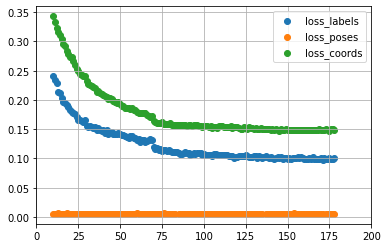

In [21]:
loss_labels = history['loss_labels']
loss_poses = history['loss_poses']
loss_coords = history['loss_coords']
index = range(len(loss_labels))

plt.scatter(index[10:], loss_labels[10:])
plt.scatter(index[10:], loss_poses[10:])
plt.scatter(index[10:], loss_coords[10:])
plt.legend(["loss_labels", "loss_poses", "loss_coords"])
plt.xlim([0,200])

plt.grid()

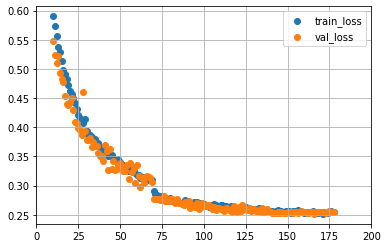

In [22]:
train_loss = history['train_loss']
val_loss = history['val_loss']
plt.scatter(index[10:], train_loss[10:])
plt.scatter(index[10:], val_loss[10:])
plt.legend(["train_loss", "val_loss"])
plt.xlim([0,200])
plt.grid()

# Inference with validation data

In [24]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.eval()
state_dict = torch.load("../model/0120_epoch167_evalLoss0.25156.pth")
model.load_state_dict(state_dict)

Using cache found in /home/takeshi/.cache/torch/hub/facebookresearch_detr_master


<All keys matched successfully>

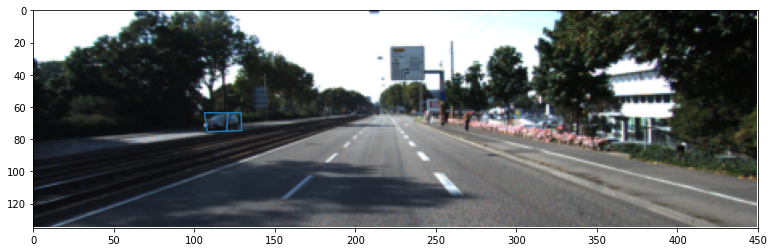

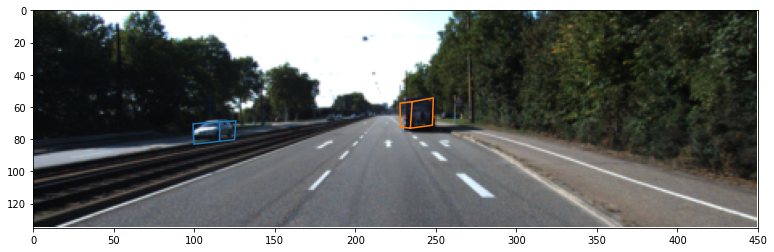

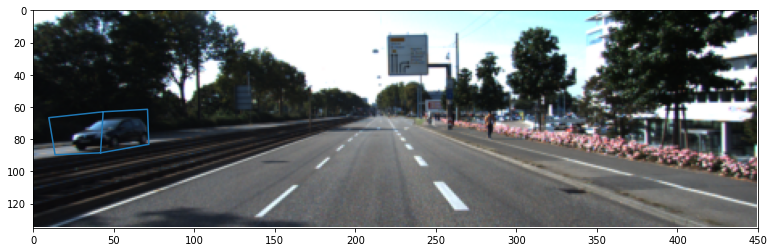

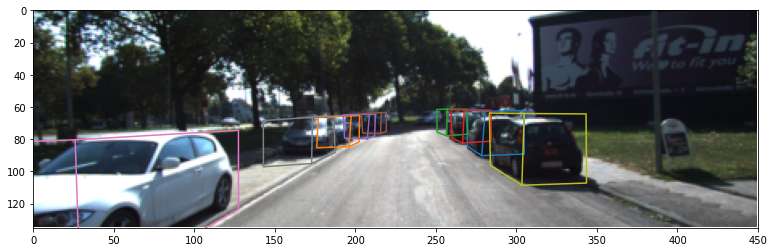

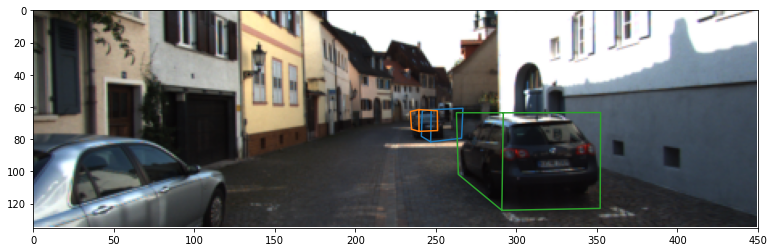

In [35]:
def drawInference(PILImage, thresh=.5):
    logit_thresh = thresh
    img = PILImage
    img = transforms.Resize([135,450])(img)
    img = tf.to_tensor(img)

    output = model(img[None])
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}

    isVehicle = np.logical_and(output["pred_logits"][:,0]>output["pred_logits"][:,1],
                               output["pred_logits"][:,0]>logit_thresh)

    plt.figure(figsize=(15, 4))
    imgshow = np.rollaxis(np.array(img),0,3)
    plt.imshow(imgshow)
    for i, flag in enumerate(isVehicle):
        if flag:
            coord = np.reshape(output["pred_coords"][i],[6,2])*np.array([imgshow.shape[1],imgshow.shape[0]])
            x = coord[:,0]
            y = coord[:,1]
            if output["pred_poses"][i]>0:
                plt.plot(x[[2,0,1,3,5,4,2,3]],y[[2,0,1,3,5,4,2,3]])
            else:
                plt.plot(x[[0,1,5,4,0]],y[[0,1,5,4,0]])
                print(output["pred_poses"][i])
    plt.xlim([0,imgshow.shape[1]])
    plt.ylim([imgshow.shape[0],0])

for i in range(5):
    img = vehicleAug.getPILImg(val_list[i+25])
    drawInference(img, thresh=.7)

In [28]:
from moviepy.editor import VideoClip, VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import HTML

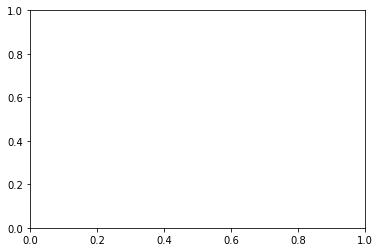

In [29]:
fig, ax = plt.subplots()
def make_frame(img, thresh=.5):
    ax.clear()
    
    logit_thresh = thresh
    crop_t = 300
    img = img[crop_t:int(crop_t+1920/450*135),:,:]
    img = Image.fromarray(np.uint8(img))
    img = transforms.Resize([135,450])(img)
    img = tf.to_tensor(img)

    output = model(img[None])
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}

    isVehicle = np.logical_and(output["pred_logits"][:,0]>output["pred_logits"][:,1],
                               output["pred_logits"][:,0]>logit_thresh)

    #ax.figure(figsize=(15, 4))
    imgshow = np.rollaxis(np.array(img),0,3)
    ax.imshow(imgshow)
    for i, flag in enumerate(isVehicle):
        if flag:
            coord = np.reshape(output["pred_coords"][i],[6,2])*np.array([imgshow.shape[1],imgshow.shape[0]])
            x = coord[:,0]
            y = coord[:,1]
            if output["pred_poses"][i]>0:
                ax.plot(x[[2,0,1,3,5,4,2,3]],y[[2,0,1,3,5,4,2,3]])
            else:
                ax.plot(x[[0,1,5,4,0]],y[[0,1,5,4,0]])
    #fig.xlim([0,imgshow.shape[1]])
    ax.set_xlim([0,imgshow.shape[1]])
    ax.set_ylim([imgshow.shape[0],0])
    
    return mplfig_to_npimage(fig)



In [30]:
output = '../output/output_video.mp4'
clip1 = VideoFileClip("../output/project_video.mp4")#.subclip(44,47)
clip = clip1.fl_image(make_frame)
clip.write_videofile(output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../output/output_video.mp4.
Moviepy - Writing video ../output/output_video.mp4



Moviepy - Done !
Moviepy - video ready ../output/output_video.mp4


In [31]:
HTML("""
<video width="450" height="135" controls>
  <source src="{0}">
</video>
""".format(output))